# <div align="center"> RAMP: AIRLINE CARRIERS PERFORMANCE PROJECT </div>
---
Authors: Soumaya SABRY | Alexandre ZAJAC | Maxime LEPEYTRE | Olivier BOIVIN | Yann KERVELLA

<div style="text-align: center">
<img src="https://github.com/alexZajac/airlines_performance/blob/master/images/airplane.png?raw=1" width="800px" />
</div>

# Table of contents
1. [Introduction](#Introduction) 
    - [Storytelling](#Story)
    - [Main Dataset](##Main_Dataset) (peut etre un peu de viz?)
    - [Weather Data](#Weather_Data)
    - [Tweeter Data](#Tweeter_Data)
2. [Data exploration](#Data_exploration)
    - [Import Python libraries](#Import)
    - [Download the data](#Download_data)
    - [Data Base](#DB) 
    - [K-nearest neighbors algorithm](#KNN)
    - [Use of Tweeter](#lars)
    - [Resgression algorithm](#lassolars)
4. [Performance metric](#Metric)
3. [Submission](#Submission) 

# Introduction <a class="anchor" id="Introduction"></a>

## Storytelling <a class="anchor" id="Story"></a>

Recently, big oil companies like BP, Total, announced that they want to reach the goal of **zero carbon** emissions, following the declarations of the governments. 
During this period of Covid-19, the ecological transition has been accelerated as we can see more investment in the renewable energy sector and especially less investment in the oil sector. To achieve this goal, each sector must reduce its emissions.

 We have chosen to focus our study on the airline industry. Following an a report on [IEA](https://www.iea.org/) (International Energy Agency). Since 2000, commercial passenger flight activity has grown by about 5% per year, while CO2 emissions rose by 2% per year, thanks to operational and technical efficiency measures. The energy intensity of commercial passenger aviation has decreased 2.8% per year ib average, but improvements have slackened over time. As we can see on this [figure](https://www.iea.org/data-and-statistics/charts/energy-intensity-of-passenger-aviation-in-the-sustainable-development-scenario-2000-2030) below, where it exposes the Sustainable Development Scenario (one RTK is generated when a metric tonne of revenue load is carried one km). 

<div style="text-align: center">
<img src="https://github.com/alexZajac/airlines_performance/blob/master/images/IEA_2.PNG?raw=1" width="800px" />
</div>

We uses the ICAO carbon calculator to understand which factors can impact the C02 emissions:


$$
C_{O2} \; per \; pax = 3.16 * (total\;fuel*pax\;to\;freight\;factor)*(number\;of\;y-seats*pax\,load\;factor)

$$

We choose to focus on the load factor as 2020 impacted it trought the pandemic
as shown in the figure below from the [report](https://ec.europa.eu/transport/sites/transport/files/legislation/com20200558_allocation_of_slots.pdf) from the commission to the european parleament and the council . We can see the average load factor for a pool of European air carriers droped from 80% in week 9 to 26% in week 15. THis is due not only to air carriers flu less, but the few remain underbooked. We want to focus our study on the load factor and it impacts on the C02 emissions.

We have chosen to focus our model on forecasting the evolution of the load factor. The aim of this forecast is to help airlines adapt their flight plans to optimize their load factor and reduce their emissions. During covid-19, their load factor is low and we want to find a way to boost the load factor (add new path or delete some paths).

<div style="text-align: center">
<img src="https://github.com/alexZajac/airlines_performance/blob/master/images/MeanLF.PNG?raw=1" width="800px" />
</div>


***What is the Passenger Load Factor ?***

$Load \space{Factor}  = \frac{RPM}{ASM}$

• RPM : Revenue Passenger Miles ($ RPM = Passengers * Distance $)

• ASM : Available Seat Miles ($ ASM = Available\space{Seats} * Distance $)

To calculate the load factor for a single flight, you can get rid of the distance term, however to calculate it over a month for a company, you've got to take into account the distance factor.

This factor is important for all transport system companies, as it assesses the performance. The majority of the revenue is made by selling tickets, to cover the high fixed costs and make profits. 

It is also important to maximize the load factor for environmental reasons, it maximizes the **fuel efficiency**. As passengers's weight represent a very low proportion of the total weight of an airplane, increasing the number of passengers lowers the fuel consumption per passengers.

Investors also look at the Airlines Load Factors as profitability indicators as airlines have very high fixed costs compared to railways companies for example. Having a high load factor is essential for any company's success. 
We can also notice that ASM is a useful metric to measure an airline's capacity to generate revenues.

We call "**break-even Load Factor**" the minimum load factor needed to cover the expenses for one flight.


## Main Dataset <a class="anchor" id="Main_Dataset"></a>  : Bureau of Transportation Statistics (BTS)

We first to chose a baseline place for building a dataset given our problem, and after a lot of investigation, we chose to go for an US-based dataset since they provide an enormous amount of databases, tables and features to chose from. Out logic was first breadth-oriented, since there exist a lot of different websites that source aviation data, but we finally settled on the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/) because it's the source for a lot of others datasets.

Preeminent source of statistics on aviation, multimodal freight activity and transportation economics.
It is a very popular and used source of informations for both political, commercial and public use.
It is part of the US Department of Transportation (DOT).

We chose to use the dataset (**T-100 Domestic Segment**) containing detailed informations on the flights for US Carriers only like  `PASSENGERS, SEATS, PAYLOAD, DESTINATION_CITY, AIRCRAFT_TYPE, ...`
We've transformed this dataset so it was indexed by `DATE` (month) and by `UNIQUE_CARRIER_NAME` on the period 2014-2019. We gathered the informations by month and by companies and enriched the dataset with statistical features, temperatures, top destinations, etc... from there. Our goal was to extract as much pertinent features as possible to make a relevant dataset that would be interesting to work on.

Since part of the data we wanted on the website wasn't directly available for all the given years (2014-2020), we put up a simple script that copied the network request from the transtats website in Node.JS (chrome only let us get the request via curL or Node.JS fetch), and from there we saw that we could modify the fields and filter parameters from the SQL query the site was running, to get all the fields we wanted.


In [12]:
main_df = pd.read_csv("data/T_Domestic_Segment_Original_All_Years.csv", index_col=0)
main_df.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,CARRIER_NAME,CARRIER_GROUP,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,MONTH,DISTANCE_GROUP,CLASS,DATE,RPM,ASM
0,0.0,1.0,22900.0,88.0,68.0,0.0,0.0,1149.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,3,F,2015-03-01,78132.0,101112.0
1,0.0,9.0,206100.0,792.0,430.0,0.0,0.0,1042.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,3,F,2015-03-01,448060.0,825264.0
2,0.0,1.0,22900.0,88.0,69.0,0.0,0.0,748.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10620,BIL,"Billings, MT",MT,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,2,F,2015-03-01,51612.0,65824.0
3,0.0,1.0,21850.0,86.0,27.0,0.0,0.0,386.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10627,BIS,"Bismarck/Mandan, ND",ND,13487,MSP,"Minneapolis, MN",MN,6,673,1,2015,3,1,F,2015-03-01,10422.0,33196.0
4,0.0,1.0,22900.0,88.0,64.0,0.0,0.0,500.0,CP,21167.0,Compass Airlines,Compass Airlines,2,11057,CLT,"Charlotte, NC",NC,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,2,F,2015-03-01,32000.0,44000.0


### **Additional Features : Weather Data with Meteostat**

We made the choice to enrich our base dataset with meteorological features, since we thought they could have a great influence on the load factor for an airline/carrier. 

On the one hand, snow, rain and crosswinds mean that air traffic controllers have to increase the gap between planes that are landing, reducing the number of aircraft that an airport can manage. The same weather can make it slower and more difficult for the planes to taxi between runway and terminal building. On the other hand, the average temperature and sunshine level on the arrival destination can influence the choice of passengers for a given carrier.

A lot of APIs provide daily or weekly live forecast for weather data but few provide an historical record for free. We finally found [the meteostat website](https://dev.meteostat.net/) that provides JSON APIs, a python library and even a web app to directly visualize weather data accross the entire globe, for free (long live open-source)!

Because the weather APIs of meteostats have a nice built-in function to determine which weather station is the closest to the city where we want to query the weather data for, we used the [geopy library](https://geopy.readthedocs.io/en/stable/) to get all the coordinates of the possibles destinations for the flights of our dataset. The weather data is then retrieved from these given weather stations.

We chose the features in line with our problem: `tavg, tmax, tsun, snow, wspd and prcp` (as given [here](https://dev.meteostat.net/python/daily.html#data-structure)). Since our data has a monthly granularity, we directly aggregated the data with the python API meteostats provides, and normalized the data to account for temporal outage of some of the sensors from the weather stations.

In [10]:
weather_df =  pd.read_csv("data/weather_dataset.csv")
weather_df.head()

FileNotFoundError: ignored

### **Additional Features : Tweeter Data with web-scraping**

It's not uncommon to include Twitter data in machine learning challenges. Since we are forecasting a load factor, which is a proxy for the performance of an airline carrier, we thought that incorporating tweets mentionning the chosen airlines could give more breadth to the features of our dataset. More precisely, by performing sentiment analysis on the tweets of a given airline, one could get a sense and new feature to test for the prediction model.

There exist an API for getting tweets from Twitter, so we signed up for a developer account, but the free version only allows to get historical data up to 7 days. So we switched to libraries performing web scraping to get tweets, and there are a lot of them (probably too much), and after a lot of trail and error we settled on [scweet](https://github.com/Altimis/Scweet), forked the repository and made a custom script for our requirements.

Since scraping 6 years of tweets for 23 carriers can be very long, our was parallelized to launch one headless chroime instance per core, with an interval of 30 days of tweets to scrape as we found this to give a good trade-off. We then set-up another script to convert all these tweets Dataframes into dataframes with sentiments probabilities (negative, neutral or positive), and for this we used the amazing [Hugging Face Transformers library](https://huggingface.co/) and more particularly the [Roberta model trained on tweets](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) to extract 3 sentiment probabilities for each tweets. As some carriers are lot less present in the Twitter feed, there are some discrepencies of dataset size and we found ways to handle them.

In [ ]:
tweeter_df =  pd.read_csv("data/tweets_dataset.csv")
tweeter_df.head()

# Data exploration <a class="anchor" id="Data_exploration"></a>

In [ ]:
#!pip install -U -r requirements.txt --user

In [28]:
# a changer si besion
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.stats import pearsonr
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
#custom
#from problem import get_data

In [124]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          'axes.labelsize' : 15,
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor": "w", 
          'figure.figsize': [20, 15], 
          'axes.prop_cycle': plt.cycler(color=color_list), 
          'figure.dpi' : 75, 
          'legend.fontsize': 10,
          'font.size': 11 
          }
plt.rcParams.update(params)

## AIRLINES CHOICE - AIRLINES PERFORMANCES

In [118]:
count_flights = main_df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS')
count_flights_f = count_flights.groupby(['UNIQUE_CARRIER_NAME'])['NB_FLIGHTS'].mean().reset_index(name = 'MOY_NB_FLIGHTS').sort_values('MOY_NB_FLIGHTS', ascending = False)
tot_pass = count_flights_f.merge(main_df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].sum().reset_index(name = 'TOT_PASS_FLIGHTS').reset_index(drop=True), on= ['UNIQUE_CARRIER_NAME']).sort_values('TOT_PASS_FLIGHTS', ascending = False)
tot_nb_flights = tot_pass.merge(main_df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].count().reset_index(name = 'TOT_NB_FLIGHTS').reset_index(drop=True), on=['UNIQUE_CARRIER_NAME']).sort_values('TOT_NB_FLIGHTS', ascending = False)

In [119]:
airlines_choice = tot_nb_flights.copy()
scaler = StandardScaler()
airlines_choice.iloc[:, 1:] = scaler.fit_transform(airlines_choice.iloc[:, 1:])
airlines_choice['TOTAL'] = airlines_choice['MOY_NB_FLIGHTS'] + airlines_choice['TOT_PASS_FLIGHTS'] + airlines_choice['TOT_NB_FLIGHTS']
airlines_choice.sort_values('TOTAL', ascending=False, inplace=True)
airlines_choice.head()

,UNIQUE_CARRIER_NAME,MOY_NB_FLIGHTS,TOT_PASS_FLIGHTS,TOT_NB_FLIGHTS,TOTAL
0,Southwest Airlines Co.,5.651950,7.051707,5.707278,18.410935
1,Delta Air Lines Inc.,5.269585,5.523008,5.323344,16.115938
3,United Air Lines Inc.,4.457456,3.429872,4.507881,12.395209
2,American Airlines Inc.,2.630861,4.842632,2.673787,10.147280
4,SkyWest Airlines Inc.,3.617594,1.286393,3.664571,8.568558


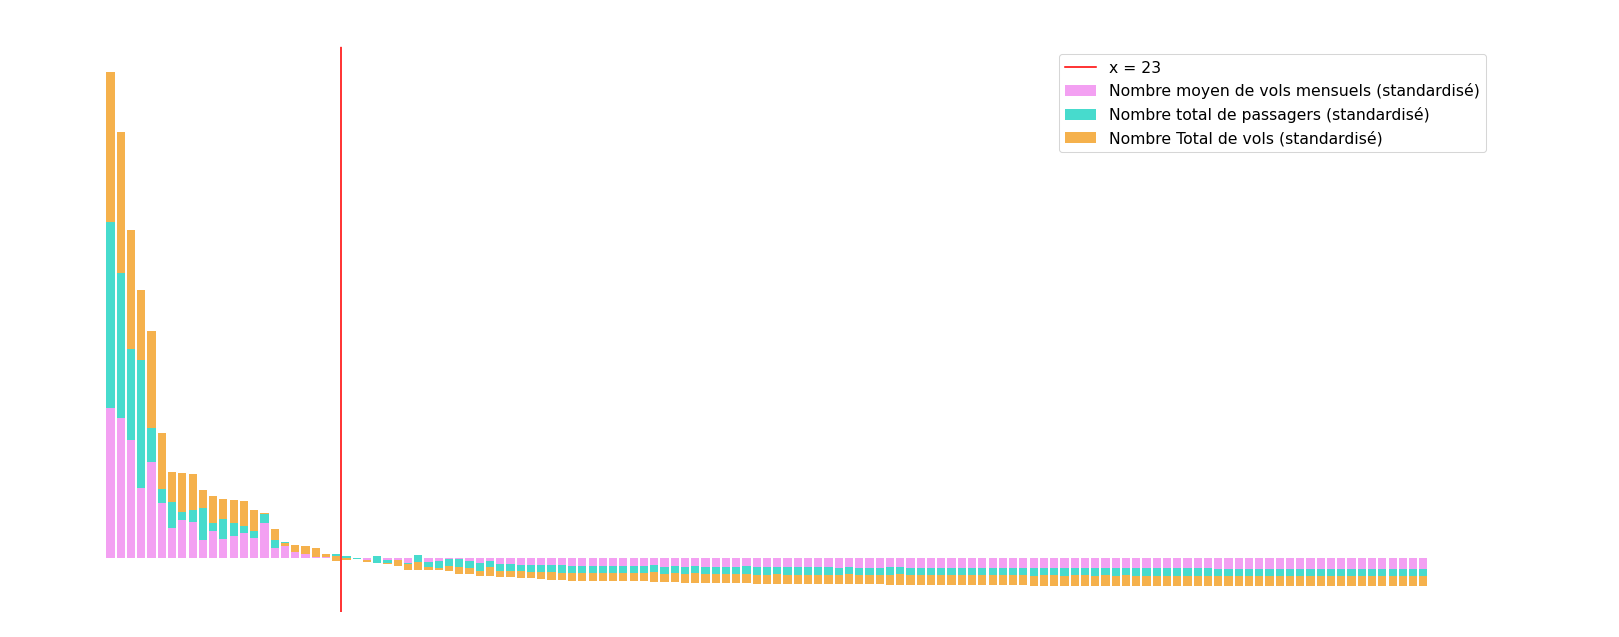

In [129]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.bar(airlines_choice['UNIQUE_CARRIER_NAME'], airlines_choice['MOY_NB_FLIGHTS'], color = 'C1', label = 'Nombre moyen de vols mensuels (standardisé)')
ax.bar(airlines_choice['UNIQUE_CARRIER_NAME'], airlines_choice['TOT_PASS_FLIGHTS'], bottom = airlines_choice['MOY_NB_FLIGHTS'], color = 'C2', label = 'Nombre total de passagers (standardisé)')
ax.bar(airlines_choice['UNIQUE_CARRIER_NAME'], airlines_choice['TOT_NB_FLIGHTS'], bottom = airlines_choice['MOY_NB_FLIGHTS'] + airlines_choice['TOT_PASS_FLIGHTS'], color = 'C3', label = 'Nombre Total de vols (standardisé)')
ax.axvline(x=22.5, color='r', linestyle='-', label = 'x = 23')
ax.legend(prop={'size': 15})
ax.set_title("Histogramme des compagnies aériennes classées selon les 3 critères sur la période 2014-2020", fontsize = 15, pad = 25)
fig.show()

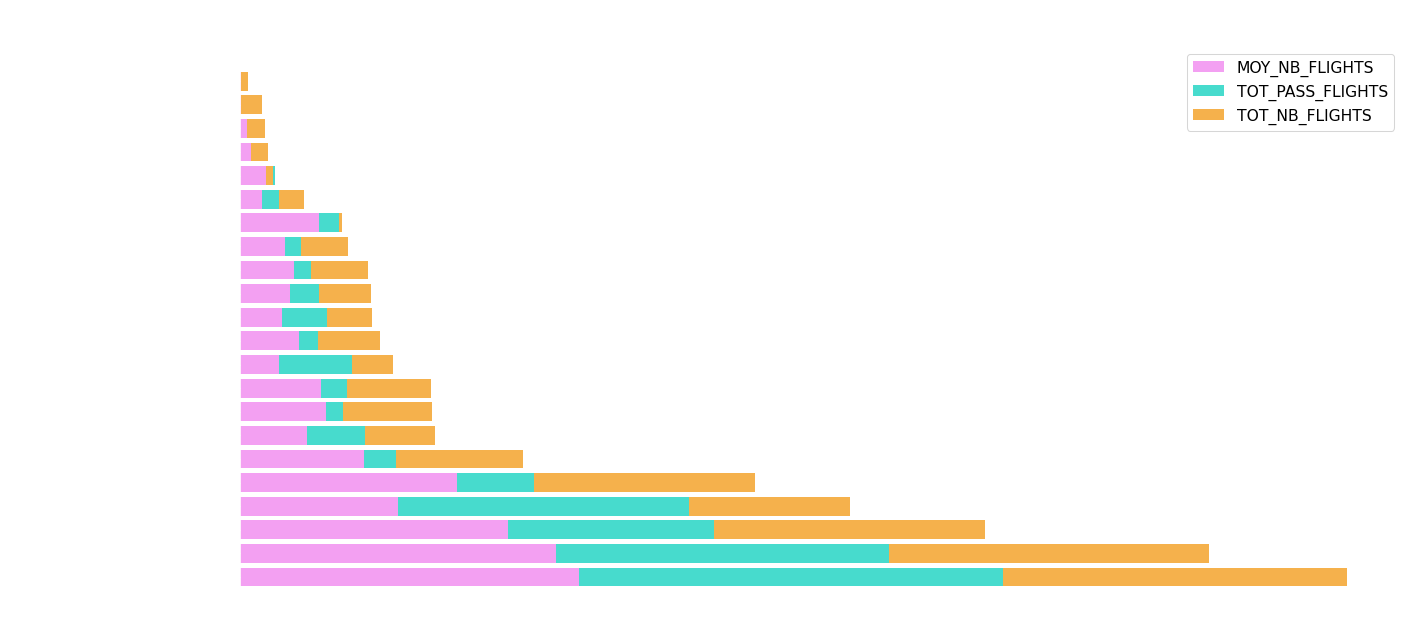

In [134]:
final_airlines = airlines_choice.iloc[:22, :].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(final_airlines['UNIQUE_CARRIER_NAME'], final_airlines['MOY_NB_FLIGHTS'], color = 'C1', label = 'MOY_NB_FLIGHTS')
ax.barh(final_airlines['UNIQUE_CARRIER_NAME'], final_airlines['TOT_PASS_FLIGHTS'], left = final_airlines['MOY_NB_FLIGHTS'], color = 'C2', label = 'TOT_PASS_FLIGHTS')
ax.barh(final_airlines['UNIQUE_CARRIER_NAME'], final_airlines['TOT_NB_FLIGHTS'], left = final_airlines['MOY_NB_FLIGHTS'] + final_airlines['TOT_PASS_FLIGHTS'], color = 'C3', label = 'TOT_NB_FLIGHTS')
ax.legend(prop={'size': 15})
ax.set_title("Histogramme des compagnies aériennes sélectionnées (23) selon les 3 critères sur la période 2014-2020", fontsize = 15, pad = 25)
fig.show()

## TRAIN DATASET DECOMPOSITION

In [29]:
X = pd.read_csv('data/train/X.csv', index_col=0)
X.head()

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,DG_1,DG_2,DG_3,DG_4,DG_5,NB_FLIGHTS,PMI,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR_SHIFTED
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,404.053512,354.642140,6.591973,8.582344e+05,0.706,0.288,0.007,0.000,0.000,299,57.0,97.41,"Charlotte, NC",71.8,0.0,25.750000,35.6,0.0,10.556667,"Philadelphia, PA",153.0,1.071429,5.460714,25.0,0.0,14.010714,"Washington, DC",247.2,0.000000,26.774194,36.7,0.0,12.212903,"Boston, MA",44.1,0.0,12.241935,24.4,0.0,18.564516,"Allentown/Bethlehem/Easton, PA",20.9,0.0,19.483871,32.2,0.0,9.603226,0.163880,6.7%,0.694164
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.202,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1173.775510,13008.870130,2729.788497,9.040299e+05,0.178,0.395,0.119,0.093,0.108,539,57.0,97.41,"Seattle, WA",34.7,0.0,8.654839,26.1,0.0,13.135484,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",24.8,0.000000,19.410000,34.4,0.0,10.113333,"Juneau, AK",76.6,0.0,5.720000,16.7,0.0,12.940000,"San Diego, CA",69.2,0.0,17.100000,32.8,0.0,7.530000,0.224490,6.7%,0.829975
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.776,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,966.379371,0.000000,0.000000,3.336490e+05,0.110,0.456,0.362,0.047,0.003,572,57.0,97.41,"Sanford, FL",327.5,0.0,23.612903,32.2,0.0,9.835484,"Las Vegas, NV",57.4,0.000000,20.403333,32.8,0.0,13.340000,"Phoenix, AZ",2.6,0.000000,24.712903,37.8,0.0,12.548387,"St. Petersburg, FL",37.7,0.0,26.770968,36.7,0.0,14.203226,"Wendover, UT",63.8,0.0,20.963333,34.4,0.0,13.746667,0.120629,6.7%,0.868898
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.0,0.0,0.000,0.006,0.0,0.000,0.284,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1123.165939,26116.628821,1301.879185,2.653638e+06,0.199,0.266,0.293,0.105,0.084,687,57.0,97.41,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Miami, FL",400.0,0.000000,28.648387,35.6,0.0,8.006452,"New York, NY",88.8,0.0,13.803333,30.6,0.0,16.133333,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667,0.197962,6.7%,0.801683
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.0,0.0,0.000,0.000,0.0,0.026,0.130,0.079,0.0,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.03,0.0,904.897127,7577.173525,6264.973214,8.985811e+05,0.299,0.352,0.161,0.128,0.052,2576,57.0,97.41,"Atlanta, GA",58.2,0.0,21.664516,32.2,0.0,10.354839,"Minneapolis, MN",198.9,0.000000,22.932258,32.8,0.0,11.887097,"Detroit, MI",37.8,71.612903,-2.496774,14.4,0.0,15.729032,"

In [63]:
aircraft_type_frequency_df = X.iloc[:, np.r_[2:, 2:54]]
aircraft_type_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.202,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.776,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.0,0.0,0.000,0.006,0.0,0.000,0.284,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.0,0.0,0.000,0.000,0.0,0.026,0.130,0.079,0.0,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.03,0.0


In [78]:
distance_features_df = X.iloc[:, np.r_[:2, 58:63]]
distance_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,DG_1,DG_2,DG_3,DG_4,DG_5
0,Air Wisconsin Airlines Corp,2014-01-01,0.706,0.288,0.007,0.000,0.000
1,Alaska Airlines Inc.,2014-01-01,0.178,0.395,0.119,0.093,0.108
2,Allegiant Air,2014-01-01,0.110,0.456,0.362,0.047,0.003
3,American Airlines Inc.,2014-01-01,0.199,0.266,0.293,0.105,0.084
4,Delta Air Lines Inc.,2014-01-01,0.299,0.352,0.161,0.128,0.052


In [44]:
top_5_dest_features_df = X.iloc[:, np.r_[:2, 66:101]]
top_5_dest_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD
0,Air Wisconsin Airlines Corp,2014-01-01,"Charlotte, NC",71.8,0.0,25.750000,35.6,0.0,10.556667,"Philadelphia, PA",153.0,1.071429,5.460714,25.0,0.0,14.010714,"Washington, DC",247.2,0.000000,26.774194,36.7,0.0,12.212903,"Boston, MA",44.1,0.0,12.241935,24.4,0.0,18.564516,"Allentown/Bethlehem/Easton, PA",20.9,0.0,19.483871,32.2,0.0,9.603226
1,Alaska Airlines Inc.,2014-01-01,"Seattle, WA",34.7,0.0,8.654839,26.1,0.0,13.135484,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",24.8,0.000000,19.410000,34.4,0.0,10.113333,"Juneau, AK",76.6,0.0,5.720000,16.7,0.0,12.940000,"San Diego, CA",69.2,0.0,17.100000,32.8,0.0,7.530000
2,Allegiant Air,2014-01-01,"Sanford, FL",327.5,0.0,23.612903,32.2,0.0,9.835484,"Las Vegas, NV",57.4,0.000000,20.403333,32.8,0.0,13.340000,"Phoenix, AZ",2.6,0.000000,24.712903,37.8,0.0,12.548387,"St. Petersburg, FL",37.7,0.0,26.770968,36.7,0.0,14.203226,"Wendover, UT",63.8,0.0,20.963333,34.4,0.0,13.746667
3,American Airlines Inc.,2014-01-01,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Miami, FL",400.0,0.000000,28.648387,35.6,0.0,8.006452,"New York, NY",88.8,0.0,13.803333,30.6,0.0,16.133333,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667
4,Delta Air Lines Inc.,2014-01-01,"Atlanta, GA",58.2,0.0,21.664516,32.2,0.0,10.354839,"Minneapolis, MN",198.9,0.000000,22.932258,32.8,0.0,11.887097,"Detroit, MI",37.8,71.612903,-2.496774,14.4,0.0,15.729032,"New York, NY",88.8,0.0,13.803333,30.6,0.0,16.133333,"Salt Lake City, UT",15.5,0.0,17.029032,33.3,0.0,13.300000


In [53]:
statistical_features_df = X.iloc[:, np.r_[:2, 54:58, 63:64]]
statistical_features_df

,UNIQUE_CARRIER_NAME,DATE,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,NB_FLIGHTS
0,Air Wisconsin Airlines Corp,2014-01-01,404.053512,354.642140,6.591973,8.582344e+05,299
1,Alaska Airlines Inc.,2014-01-01,1173.775510,13008.870130,2729.788497,9.040299e+05,539
2,Allegiant Air,2014-01-01,966.379371,0.000000,0.000000,3.336490e+05,572
3,American Airlines Inc.,2014-01-01,1123.165939,26116.628821,1301.879185,2.653638e+06,687
4,Delta Air Lines Inc.,2014-01-01,904.897127,7577.173525,6264.973214,8.985811e+05,2576
...,...,...,...,...,...,...,...
1009,SkyWest Airlines Inc.,2017-12-01,545.118173,0.000000,0.000000,4.185142e+05,2124
1010,Southwest Airlines Co.,2017-12-01,901.288213,10166.315702,0.000000,1.681327e+06,2401
1011,Spirit Air Lines,2017-12-01,1038.800000,0.000000,0.000000,9.345952e+05,505
1012,Sun Country Airlines d/b/a MN Airlines,2017-12-01,1040.967164,742.844776,4909.543284,2.350651e+05,335


In [46]:
top_1_dest_frequency_df = X.iloc[:, np.r_[:2, 101]]
top_1_dest_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP_1_DEST_FQ
0,Air Wisconsin Airlines Corp,2014-01-01,0.163880
1,Alaska Airlines Inc.,2014-01-01,0.224490
2,Allegiant Air,2014-01-01,0.120629
3,American Airlines Inc.,2014-01-01,0.197962
4,Delta Air Lines Inc.,2014-01-01,0.189053


In [58]:
other_features = X.iloc[:, np.r_[:2, 64:66, 102:104]]
other_features.head()

,UNIQUE_CARRIER_NAME,DATE,PMI,Price,UNEMPLOYMENT,LOAD_FACTOR_SHIFTED
0,Air Wisconsin Airlines Corp,2014-01-01,57.0,97.41,6.7%,0.694164
1,Alaska Airlines Inc.,2014-01-01,57.0,97.41,6.7%,0.829975
2,Allegiant Air,2014-01-01,57.0,97.41,6.7%,0.868898
3,American Airlines Inc.,2014-01-01,57.0,97.41,6.7%,0.801683
4,Delta Air Lines Inc.,2014-01-01,57.0,97.41,6.7%,0.804674


## AIRCRAFT TYPE FREQUENCY

In [64]:
aircraft_type_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.202,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.776,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.0,0.0,0.000,0.006,0.0,0.000,0.284,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.0,0.0,0.000,0.000,0.0,0.026,0.130,0.079,0.0,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.03,0.0


In [65]:
config_aircraft = pd.read_csv('data/L_AIRCRAFT_TYPE.csv_')
config_aircraft.head()

,Code,Description
0,7,Aero Commander 200
1,8,Aero Macchi AL-60
2,9,Aeronca 7-AC
3,10,Beech Bonanza 35A/C/D/E/G/H/J/K/S/V/ 36A
4,20,Bellanca CH-300


In [66]:
columns = aircraft_type_frequency_df.columns[2:]
new_columns = ['UNIQUE_CARRIER_NAME', 'DATE']
for column_name in columns:
  new_columns.append(config_aircraft[config_aircraft['Code']== int(column_name)]['Description'].values[0])
aircraft_type_frequency_df.columns = new_columns
aircraft_type_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,Piper PA-31 (Navajo)/T-1020,Gipps Aero Ga8 Airvan,Airbus Industrie A330-900,Cessna C206/207/209/210 Stationair,Airbus Industrie A350-900,Beech 200 Super Kingair,Cessna 208 Caravan,Embraer EMB-120 Brasilia,De Havilland DHC8-400 Dash-8,Bombardier CRJ550,Boeing 717-200,Boeing 737-700/700LR/Max 7,Boeing 737-800,Boeing 737-500,Boeing 737-400,Boeing 737-300,Boeing 757-200,Boeing 757-300,Boeing 767-400/ER,Boeing 767-200/ER/EM,Boeing 767-300/300ER,Boeing 777-200ER/200LR/233LR,Canadair RJ-200ER /RJ-440,Canadair RJ-700,Boeing 737-900,Boeing 777-300/300ER/333ER,Canadair CRJ 900,McDonnell Douglas DC-9-50,McDonnell Douglas DC9 Super 80/MD81/82/83/88,McDonnell Douglas MD-90,Embraer ERJ-175,Embraer-135,Embraer-145,Embraer-140,Embraer-Emb-170,Embraer 190,Airbus Industrie A330-300,Airbus Industrie A320-100/200,Airbus Industrie A330-200,Airbus Industrie A319,Airbus Industrie A321/Lr,Airbus Industrie A321-200n,Airbus Industrie A320-200n,A200-100 BD-500-1A10,Boeing 747-400,Boeing 747SP,Boeing 787-10 Dreamliner,Boeing B737 Max 800,Boeing B737 Max 900,B787-800 Dreamliner,Boeing 737-900ER,B787-900 Dreamliner
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.202,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.776,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.0,0.0,0.000,0.006,0.0,0.000,0.284,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.0,0.0,0.000,0.000,0.0,0.026,0.130,0.079,0.0,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.03,0.0


In [67]:
visualisation_df = aircraft_type_frequency_df[(aircraft_type_frequency_df['UNIQUE_CARRIER_NAME'] == 'SkyWest Airlines Inc.')]
visualisation_df['DATE'] = pd.to_datetime(visualisation_df['DATE'])
visualisation_df = visualisation_df.loc[:, (visualisation_df != 0).any(axis=0)]
visualisation_df.head()

,UNIQUE_CARRIER_NAME,DATE,Embraer EMB-120 Brasilia,Canadair RJ-200ER /RJ-440,Canadair RJ-700,Canadair CRJ 900,Embraer ERJ-175
16,SkyWest Airlines Inc.,2014-01-01,0.072,0.437,0.385,0.106,0.0
38,SkyWest Airlines Inc.,2014-02-01,0.078,0.439,0.379,0.103,0.0
60,SkyWest Airlines Inc.,2014-03-01,0.075,0.433,0.377,0.114,0.0
82,SkyWest Airlines Inc.,2014-04-01,0.078,0.442,0.335,0.145,0.0
104,SkyWest Airlines Inc.,2014-05-01,0.070,0.437,0.352,0.140,0.0


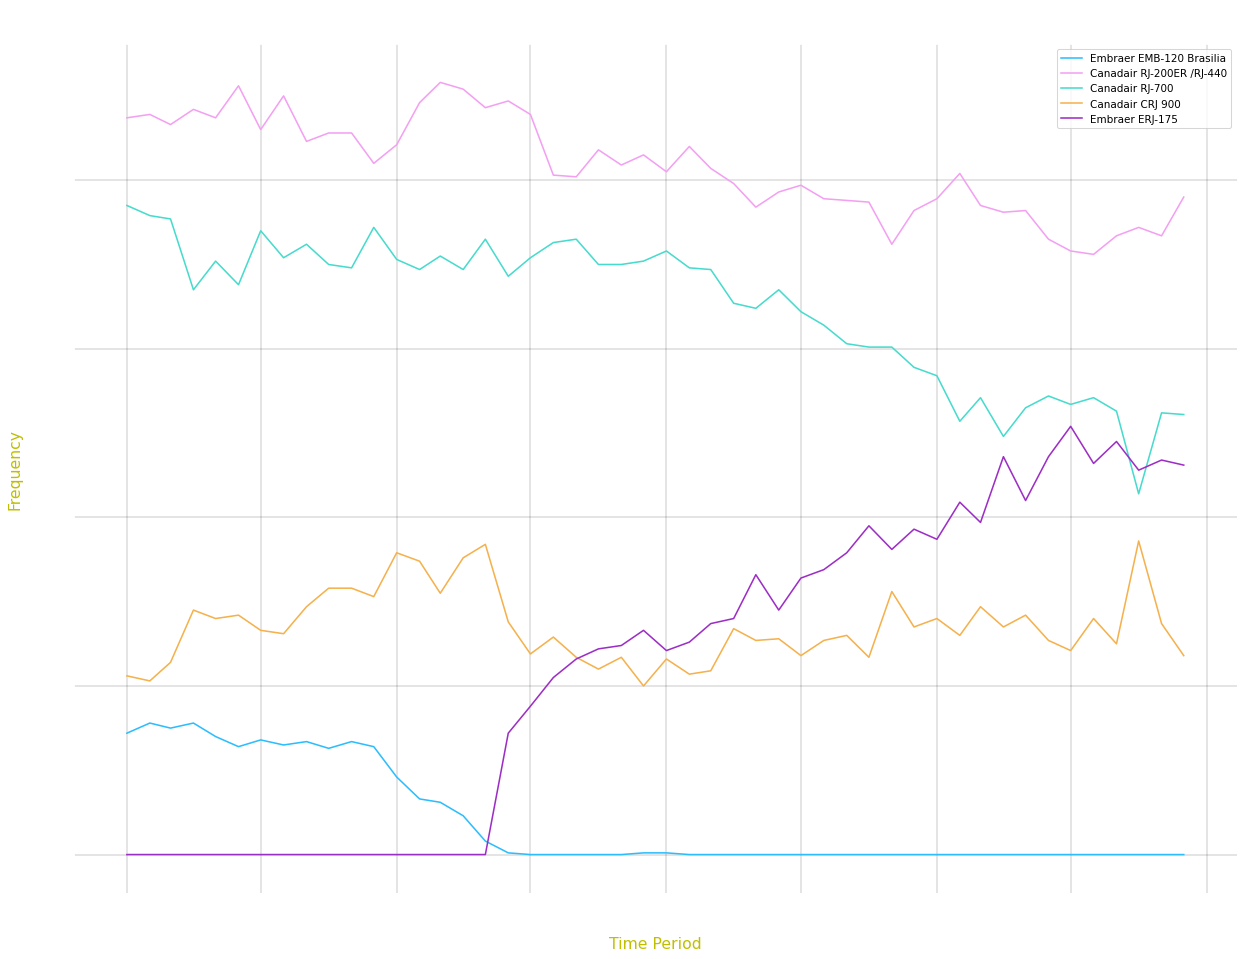

In [70]:
plt.figure()
plt.grid(True, linewidth=0.2, color='black', linestyle='-')
plt.plot(visualisation_df['DATE'], visualisation_df.iloc[:, 2:])
plt.legend(visualisation_df.iloc[:, 2:].columns)
plt.xlabel("Time Period", color = 'y', labelpad = 25)
plt.ylabel("Frequency", color = 'y', labelpad = 25)
plt.title("Aircraft Usage Frequency of SkyWest Airlines over the period 2014 - 2019", pad = 25)
plt.show()

## DISTANCE FEATURES

In [79]:
distance_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,DG_1,DG_2,DG_3,DG_4,DG_5
0,Air Wisconsin Airlines Corp,2014-01-01,0.706,0.288,0.007,0.000,0.000
1,Alaska Airlines Inc.,2014-01-01,0.178,0.395,0.119,0.093,0.108
2,Allegiant Air,2014-01-01,0.110,0.456,0.362,0.047,0.003
3,American Airlines Inc.,2014-01-01,0.199,0.266,0.293,0.105,0.084
4,Delta Air Lines Inc.,2014-01-01,0.299,0.352,0.161,0.128,0.052


In [80]:
config_dist = pd.read_csv('data/L_DISTANCE_GROUP_500.csv_')
config_dist.head()

,Code,Description
0,1,Less Than 500 Miles
1,2,500-999 Miles
2,3,1000-1499 Miles
3,4,1500-1999 Miles
4,5,2000-2499 Miles


In [81]:
distance_features_df['DATE'] = pd.to_datetime(distance_features_df['DATE'])
distance_features_df = distance_features_df[distance_features_df['UNIQUE_CARRIER_NAME'] == 'Southwest Airlines Co.']
distance_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,DG_1,DG_2,DG_3,DG_4,DG_5
17,Southwest Airlines Co.,2014-01-01,0.325,0.370,0.202,0.087,0.016
39,Southwest Airlines Co.,2014-02-01,0.327,0.372,0.208,0.080,0.014
61,Southwest Airlines Co.,2014-03-01,0.315,0.368,0.216,0.088,0.014
83,Southwest Airlines Co.,2014-04-01,0.320,0.377,0.208,0.082,0.013
105,Southwest Airlines Co.,2014-05-01,0.339,0.373,0.195,0.081,0.012


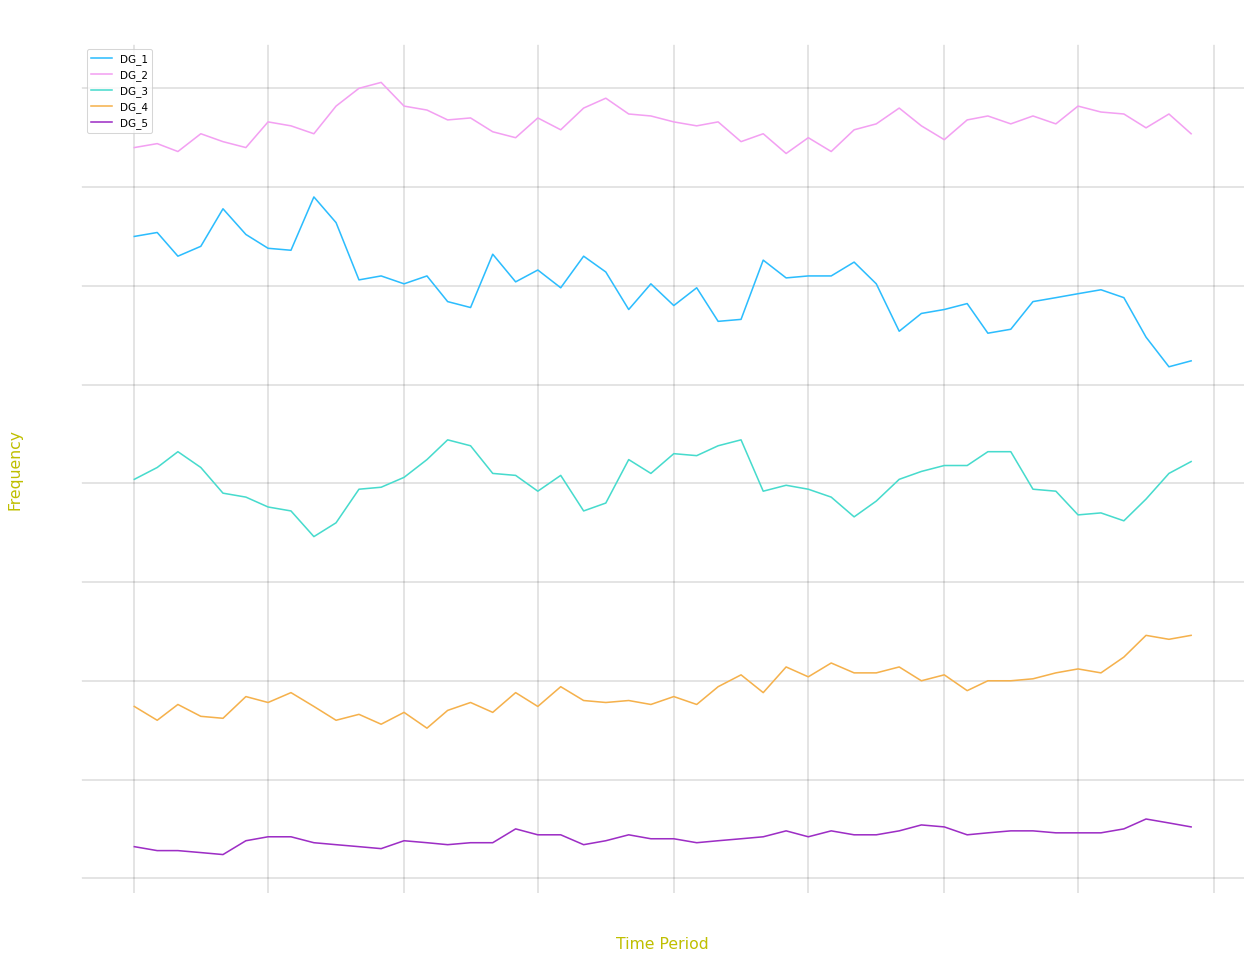

In [82]:
plt.figure()
plt.grid(True, linewidth=0.2, color='black', linestyle='-')
plt.plot(distance_features_df['DATE'], distance_features_df.iloc[:, 2:])
plt.legend(distance_features_df.iloc[:, 2:].columns)
plt.xlabel("Time Period", color = 'y', labelpad = 25)
plt.ylabel("Frequency", color = 'y', labelpad = 25)
plt.title("Frequency of flights by distance group of SkyWest Airlines over the period 2014 - 2019", pad = 25)
plt.show()

## TOP 5 DESTINATIONS FEATURES

In [89]:
top_5_dest_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD
16,SkyWest Airlines Inc.,2014-01-01,"Salt Lake City, UT",15.5,0.0,17.029032,33.3,0.0,13.300000,"Denver, CO",545.5,0.0,27.010000,32.8,0.0,0.000000,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667,"Houston, TX",105.9,0.0,28.256667,35.0,0.0,12.226667
38,SkyWest Airlines Inc.,2014-02-01,"Salt Lake City, UT",6.3,0.0,24.933333,38.3,0.0,13.876667,"Denver, CO",683.6,0.0,26.090323,31.9,0.0,0.000000,"Chicago, IL",160.2,7.322581,5.283333,17.8,0.0,18.313333,"Houston, TX",202.9,0.0,29.070968,37.8,0.0,9.751613,"Los Angeles, CA",10.9,0.0,15.680645,22.2,0.0,13.425806
60,SkyWest Airlines Inc.,2014-03-01,"Salt Lake City, UT",13.1,0.0,29.567742,40.6,0.0,13.445161,"Denver, CO",429.3,0.0,24.720000,32.3,0.0,0.000000,"Chicago, IL",25.3,19.580645,-2.600000,9.4,0.0,17.019355,"Los Angeles, CA",0.3,0.0,18.386667,29.4,0.0,12.236667,"Houston, TX",42.9,0.0,29.051613,37.8,0.0,9.790323
82,SkyWest Airlines Inc.,2014-04-01,"Salt Lake City, UT",1.8,0.0,27.303226,38.3,0.0,12.951613,"Denver, CO",537.0,0.0,24.809677,31.2,0.0,0.000000,"Chicago, IL",33.5,8.724138,0.255172,18.3,0.0,18.686207,"Los Angeles, CA",8.9,0.0,20.690323,30.0,0.0,12.996774,"Houston, TX",209.6,0.0,26.630000,35.0,0.0,9.626667
104,SkyWest Airlines Inc.,2014-05-01,"Denver, CO",374.7,0.0,25.145161,32.6,0.0,0.000000,"Salt Lake City, UT",51.9,0.0,19.466667,36.7,0.0,12.616667,"Chicago, IL",84.7,0.806452,7.176667,22.8,0.0,17.030000,"Los Angeles, CA",0.0,0.0,22.083871,30.0,0.0,11.787097,"Houston, TX",174.8,0.0,22.596774,33.3,0.0,13.180645


In [90]:
# Get Data for a certain company and reindex columns so they are sorted
top_5_dest_features_df = top_5_dest_features_df[top_5_dest_features_df['UNIQUE_CARRIER_NAME'] == 'SkyWest Airlines Inc.']
top_5_dest_features_df['DATE'] = pd.to_datetime(top_5_dest_features_df['DATE'])
top_5_dest_features_df = top_5_dest_features_df.reindex(sorted(top_5_dest_features_df.columns), axis=1)
tmp_col = top_5_dest_features_df.pop('UNIQUE_CARRIER_NAME')
top_5_dest_features_df.insert(0, 'UNIQUE_CARRIER_NAME', tmp_col)
top_5_dest_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD
16,SkyWest Airlines Inc.,2014-01-01,"Salt Lake City, UT",15.5,0.0,17.029032,33.3,0.0,13.300000,"Denver, CO",545.5,0.0,27.010000,32.8,0.0,0.000000,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667,"Houston, TX",105.9,0.0,28.256667,35.0,0.0,12.226667
38,SkyWest Airlines Inc.,2014-02-01,"Salt Lake City, UT",6.3,0.0,24.933333,38.3,0.0,13.876667,"Denver, CO",683.6,0.0,26.090323,31.9,0.0,0.000000,"Chicago, IL",160.2,7.322581,5.283333,17.8,0.0,18.313333,"Houston, TX",202.9,0.0,29.070968,37.8,0.0,9.751613,"Los Angeles, CA",10.9,0.0,15.680645,22.2,0.0,13.425806
60,SkyWest Airlines Inc.,2014-03-01,"Salt Lake City, UT",13.1,0.0,29.567742,40.6,0.0,13.445161,"Denver, CO",429.3,0.0,24.720000,32.3,0.0,0.000000,"Chicago, IL",25.3,19.580645,-2.600000,9.4,0.0,17.019355,"Los Angeles, CA",0.3,0.0,18.386667,29.4,0.0,12.236667,"Houston, TX",42.9,0.0,29.051613,37.8,0.0,9.790323
82,SkyWest Airlines Inc.,2014-04-01,"Salt Lake City, UT",1.8,0.0,27.303226,38.3,0.0,12.951613,"Denver, CO",537.0,0.0,24.809677,31.2,0.0,0.000000,"Chicago, IL",33.5,8.724138,0.255172,18.3,0.0,18.686207,"Los Angeles, CA",8.9,0.0,20.690323,30.0,0.0,12.996774,"Houston, TX",209.6,0.0,26.630000,35.0,0.0,9.626667
104,SkyWest Airlines Inc.,2014-05-01,"Denver, CO",374.7,0.0,25.145161,32.6,0.0,0.000000,"Salt Lake City, UT",51.9,0.0,19.466667,36.7,0.0,12.616667,"Chicago, IL",84.7,0.806452,7.176667,22.8,0.0,17.030000,"Los Angeles, CA",0.0,0.0,22.083871,30.0,0.0,11.787097,"Houston, TX",174.8,0.0,22.596774,33.3,0.0,13.180645


In [91]:
df_tavg = top_5_dest_features_df[['DATE','TOP1_TAVG', 'TOP2_TAVG', 'TOP3_TAVG', 'TOP4_TAVG', 'TOP5_TAVG']]
avg_tmp = df_tavg.iloc[:, 1:].mean(axis=1)
df_tavg['AVG'] = avg_tmp
df_tavg.head()

,DATE,TOP1_TAVG,TOP2_TAVG,TOP3_TAVG,TOP4_TAVG,TOP5_TAVG,AVG
16,2014-01-01,17.029032,27.010000,8.486667,16.496667,28.256667,19.455806
38,2014-02-01,24.933333,26.090323,5.283333,29.070968,15.680645,20.211720
60,2014-03-01,29.567742,24.720000,-2.600000,18.386667,29.051613,19.825204
82,2014-04-01,27.303226,24.809677,0.255172,20.690323,26.630000,19.937680
104,2014-05-01,25.145161,19.466667,7.176667,22.083871,22.596774,19.293828


In [92]:
df_prcp = top_5_dest_features_df[['DATE','TOP1_PRCP', 'TOP2_PRCP', 'TOP3_PRCP', 'TOP4_PRCP', 'TOP5_PRCP']]
avg_prcp = df_prcp.iloc[:, 1:].mean(axis=1)
df_prcp['AVG'] = avg_prcp
df_prcp.head()

,DATE,TOP1_PRCP,TOP2_PRCP,TOP3_PRCP,TOP4_PRCP,TOP5_PRCP,AVG
16,2014-01-01,15.5,545.5,123.9,2.8,105.9,158.72
38,2014-02-01,6.3,683.6,160.2,202.9,10.9,212.78
60,2014-03-01,13.1,429.3,25.3,0.3,42.9,102.18
82,2014-04-01,1.8,537.0,33.5,8.9,209.6,158.16
104,2014-05-01,374.7,51.9,84.7,0.0,174.8,137.22


In [93]:
df_wspd = top_5_dest_features_df[['DATE','TOP1_WSPD', 'TOP2_WSPD', 'TOP3_WSPD', 'TOP4_WSPD', 'TOP5_WSPD']]
avg_wspd = df_wspd.iloc[:, 1:].mean(axis=1)
df_wspd.loc[:, 'AVG'] = avg_wspd
df_wspd.head()

,DATE,TOP1_WSPD,TOP2_WSPD,TOP3_WSPD,TOP4_WSPD,TOP5_WSPD,AVG
16,2014-01-01,13.300000,0.000000,18.226667,13.076667,12.226667,11.366000
38,2014-02-01,13.876667,0.000000,18.313333,9.751613,13.425806,11.073484
60,2014-03-01,13.445161,0.000000,17.019355,12.236667,9.790323,10.498301
82,2014-04-01,12.951613,0.000000,18.686207,12.996774,9.626667,10.852252
104,2014-05-01,0.000000,12.616667,17.030000,11.787097,13.180645,10.922882


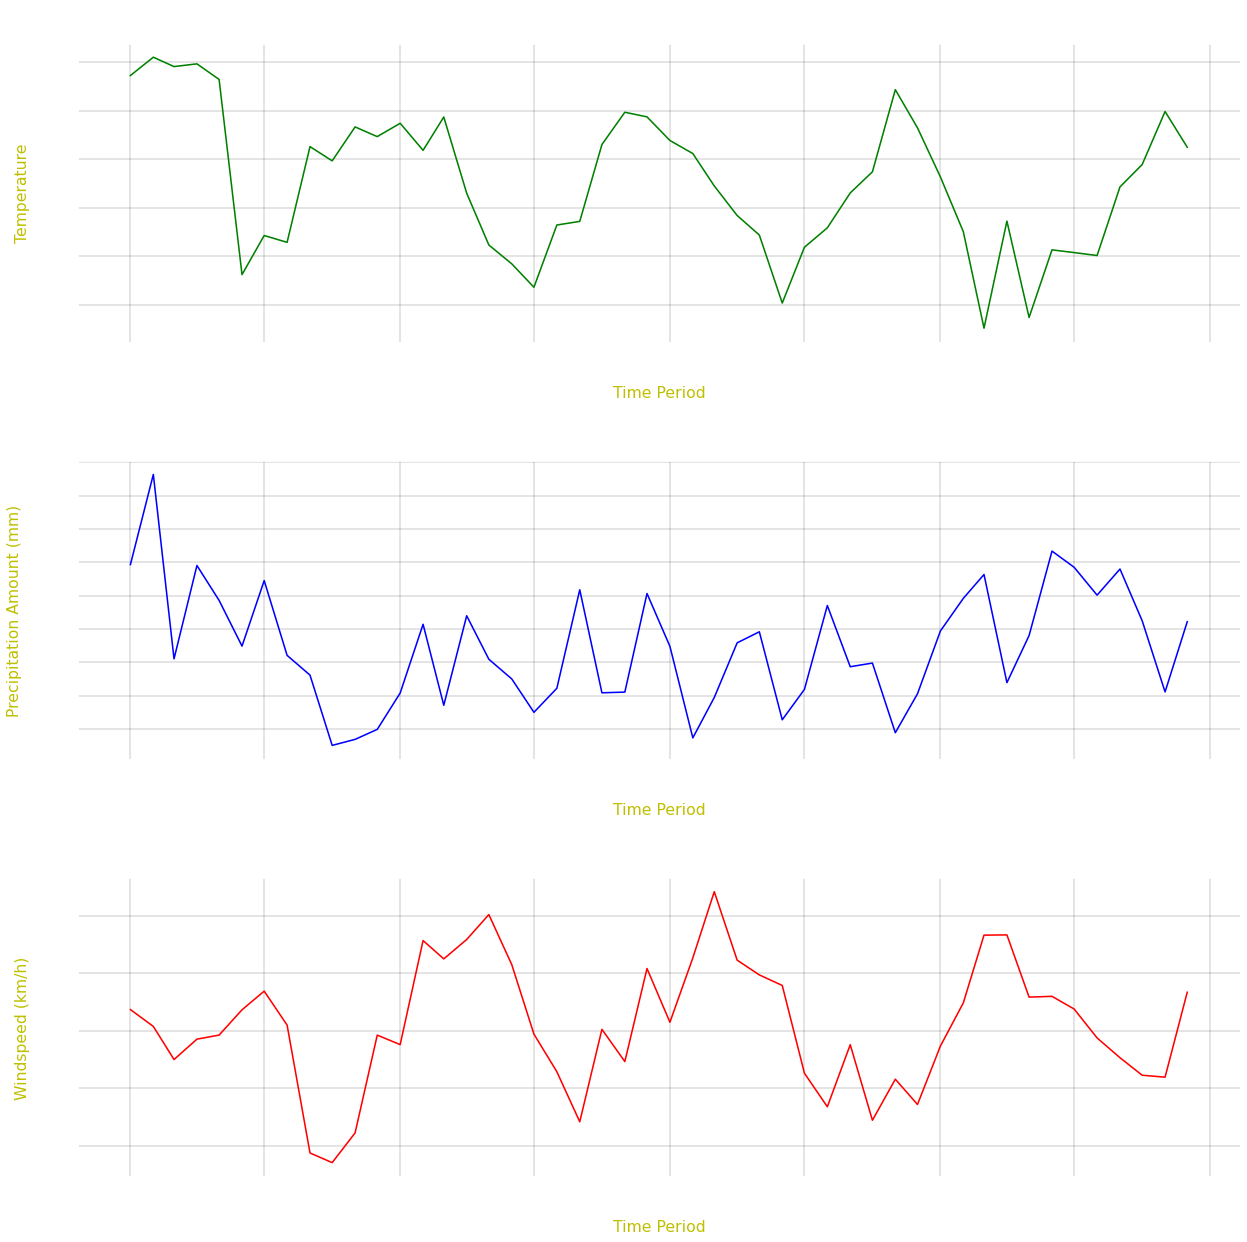

In [95]:
fig, axs = plt.subplots(3, figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
axs[0].grid(True, linewidth=0.2, color='black', linestyle='-')
axs[0].plot(df_tavg['DATE'], avg_tmp, 'g')
axs[0].set_xlabel("Time Period", color = 'y', labelpad = 25)
axs[0].set_ylabel("Temperature", color = 'y', labelpad = 25)
axs[0].set_title("Average Temperature among top 5 destinations of SkyWest Airlines over the period 2014 - 2019", pad = 25)
axs[1].grid(True, linewidth=0.2, color='black', linestyle='-')
axs[1].plot(df_tavg['DATE'], avg_prcp, 'b')
axs[1].set_xlabel("Time Period", color = 'y', labelpad = 25)
axs[1].set_ylabel("Precipitation Amount (mm)", color = 'y', labelpad = 25)
axs[1].set_title("Average precipitation amount among top 5 destinations of SkyWest Airlines over the period 2014 - 2019", pad = 25)
axs[2].grid(True, linewidth=0.2, color='black', linestyle='-')
axs[2].plot(df_tavg['DATE'], avg_wspd, 'r')
axs[2].set_xlabel("Time Period", color = 'y', labelpad = 25)
axs[2].set_ylabel("Windspeed (km/h)", color = 'y', labelpad = 25)
axs[2].set_title("Average windspeed among top 5 destinations of SkyWest Airlines over the period 2014 - 2019", pad = 25)
fig.show()

## STATISTICAL FEATURES

In [100]:
statistical_features_df['DATE'] = pd.to_datetime(statistical_features_df['DATE'])
statistical_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,NB_FLIGHTS
4,Delta Air Lines Inc.,2014-01-01,904.897127,7577.173525,6264.973214,8.985811e+05,2576
26,Delta Air Lines Inc.,2014-02-01,911.509735,8773.143363,5667.393363,9.689106e+05,2260
48,Delta Air Lines Inc.,2014-03-01,899.996296,9717.263786,6183.986420,1.129333e+06,2430
70,Delta Air Lines Inc.,2014-04-01,852.755374,9194.553740,5825.522786,1.186201e+06,2326
92,Delta Air Lines Inc.,2014-05-01,870.864007,10662.920206,5158.264264,1.174597e+06,2331


In [101]:
statistical_features_df = statistical_features_df[statistical_features_df['UNIQUE_CARRIER_NAME'] == 'Delta Air Lines Inc.']
statistical_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,NB_FLIGHTS
4,Delta Air Lines Inc.,2014-01-01,904.897127,7577.173525,6264.973214,8.985811e+05,2576
26,Delta Air Lines Inc.,2014-02-01,911.509735,8773.143363,5667.393363,9.689106e+05,2260
48,Delta Air Lines Inc.,2014-03-01,899.996296,9717.263786,6183.986420,1.129333e+06,2430
70,Delta Air Lines Inc.,2014-04-01,852.755374,9194.553740,5825.522786,1.186201e+06,2326
92,Delta Air Lines Inc.,2014-05-01,870.864007,10662.920206,5158.264264,1.174597e+06,2331


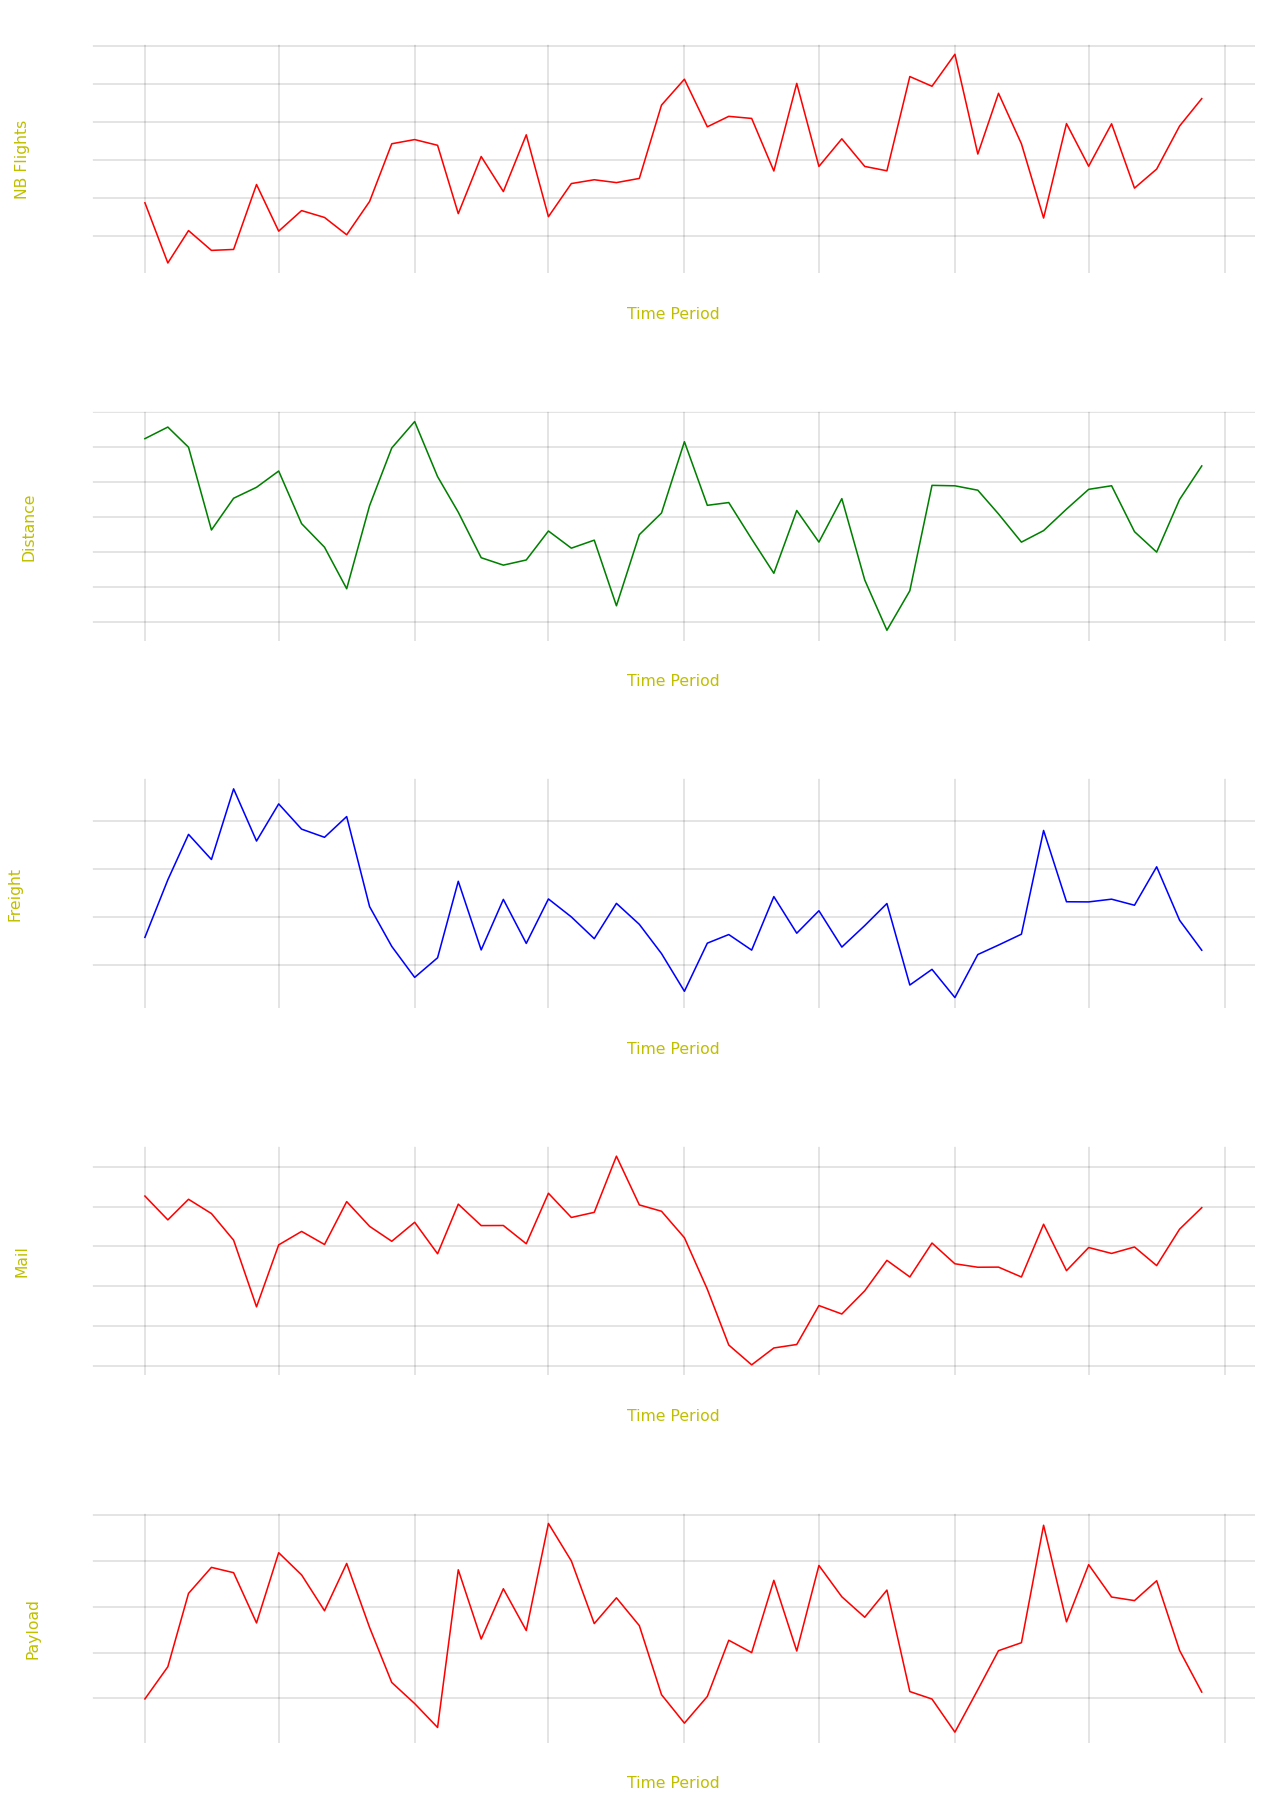

In [104]:
fig, axs = plt.subplots(5, figsize=(20, 30))
fig.subplots_adjust(hspace = 0.6)

for ax in axs:
  ax.grid(True, linewidth=0.2, color='black', linestyle='-')
  ax.set_xlabel("Time Period", color = 'y', labelpad = 15)

axs[0].plot(statistical_features_df['DATE'], statistical_features_df['NB_FLIGHTS'], 'r')
axs[0].set_ylabel("NB Flights", color = 'y', labelpad = 25)
axs[0].set_title("Number of Flights Evolution of Delta Air Lines over the period 2014 - 2019", pad = 25)

axs[1].plot(statistical_features_df['DATE'], statistical_features_df['AVG_DIST'], 'g')
axs[1].set_ylabel("Distance", color = 'y', labelpad = 25)
axs[1].set_title("Average Distance Evolution of Delta Air Lines over the period 2014 - 2019", pad = 25)

axs[2].plot(statistical_features_df['DATE'], statistical_features_df['AVG_FREIGHT'], 'b')
axs[2].set_ylabel("Freight", color = 'y', labelpad = 25)
axs[2].set_title("Average Freight Evolution of Delta Air Lines over the period 2014 - 2019", pad = 25)

axs[3].plot(statistical_features_df['DATE'], statistical_features_df['AVG_MAIL'], 'r')
axs[3].set_ylabel("Mail", color = 'y', labelpad = 25)
axs[3].set_title("Average Mail Evolution of Delta Air Lines over the period 2014 - 2019", pad = 25)

axs[4].plot(statistical_features_df['DATE'], statistical_features_df['AVG_PAYLOAD'], 'r')
axs[4].set_ylabel("Payload", color = 'y', labelpad = 25)
axs[4].set_title("Average Payload Evolution of Delta Air Lines over the period 2014 - 2019", pad = 25)
fig.show()

## TOP 1 DESTINATION FREQUENCY FEATURE

In [106]:
top_1_dest_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP_1_DEST_FQ
0,Air Wisconsin Airlines Corp,2014-01-01,0.163880
1,Alaska Airlines Inc.,2014-01-01,0.224490
2,Allegiant Air,2014-01-01,0.120629
3,American Airlines Inc.,2014-01-01,0.197962
4,Delta Air Lines Inc.,2014-01-01,0.189053


In [107]:
carriers = ['American Airlines Inc.', 'SkyWest Airlines Inc.', 'Delta Air Lines Inc.', 'Southwest Airlines Co.']
top_1_dest_frequency_df = top_1_dest_frequency_df[top_1_dest_frequency_df['UNIQUE_CARRIER_NAME'].isin(carriers)]
top_1_dest_frequency_df['DATE'] = pd.to_datetime(top_1_dest_frequency_df['DATE'])
top_1_dest_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP_1_DEST_FQ
3,American Airlines Inc.,2014-01-01,0.197962
4,Delta Air Lines Inc.,2014-01-01,0.189053
16,SkyWest Airlines Inc.,2014-01-01,0.086109
17,Southwest Airlines Co.,2014-01-01,0.058928
25,American Airlines Inc.,2014-02-01,0.198251


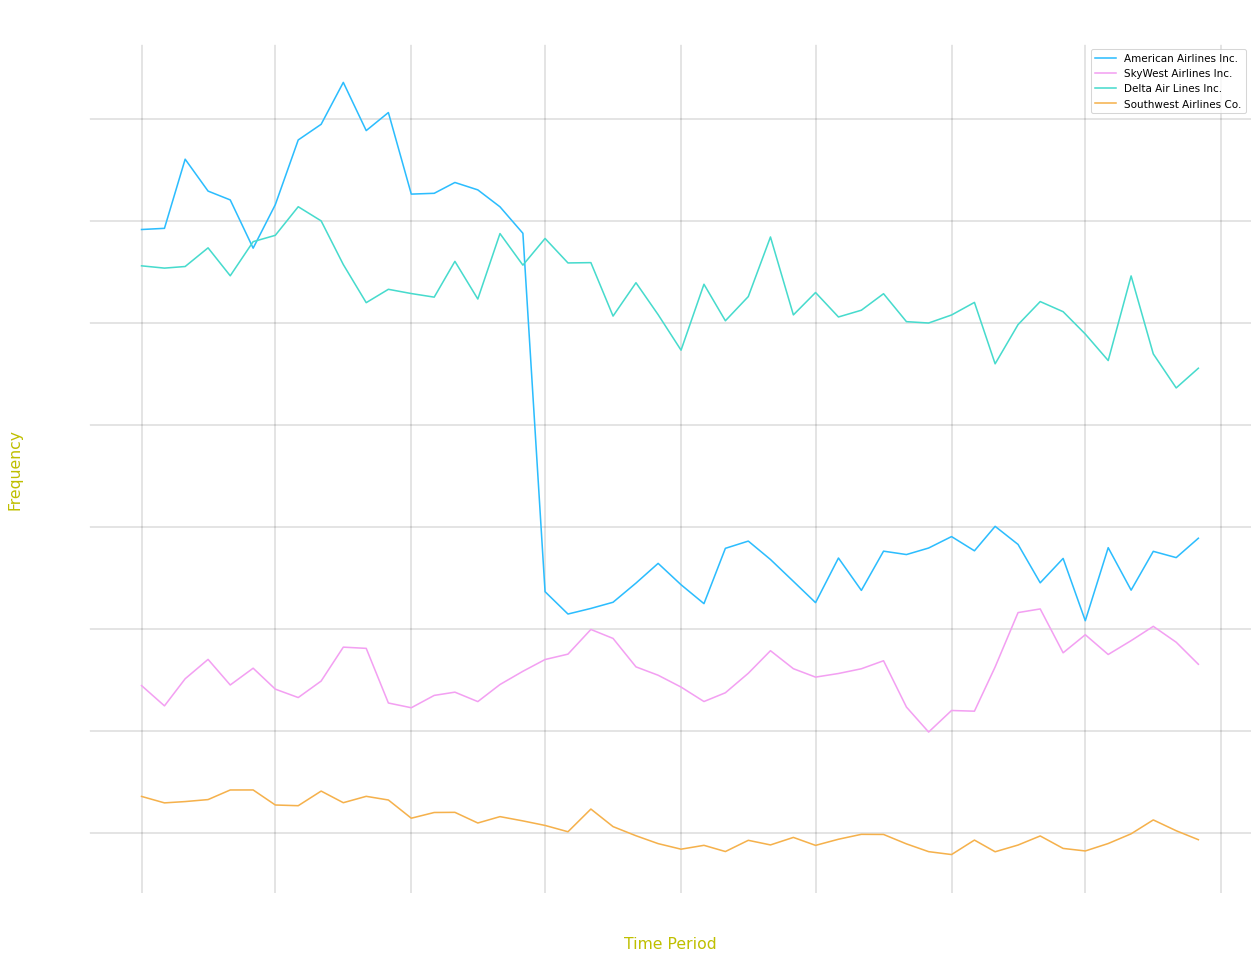

In [108]:
plt.figure()
for carrier in carriers:
  tmp = top_1_dest_frequency_df[top_1_dest_frequency_df['UNIQUE_CARRIER_NAME'] == carrier]
  plt.grid(True, linewidth=0.2, color='black', linestyle='-')
  plt.plot(tmp['DATE'], tmp['TOP_1_DEST_FQ'])
plt.legend(carriers)
plt.xlabel("Time Period", color = 'y', labelpad = 25)
plt.ylabel("Frequency", color = 'y', labelpad = 25)
plt.title("Flights Frequency of top 1 destination for some air carriers over the period 2014 - 2019", pad = 25)
plt.show()

## SEASONALITY

In [110]:
y = pd.read_csv('data/train/y.csv', index_col=0)
y.head()

,Unnamed: 0,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,0,Air Wisconsin Airlines Corp,2014-01-01,0.739282
1,1,Alaska Airlines Inc.,2014-01-01,0.827900
2,2,Allegiant Air,2014-01-01,0.855015
3,3,American Airlines Inc.,2014-01-01,0.807851
4,4,Delta Air Lines Inc.,2014-01-01,0.820928


In [112]:
y2 = pd.read_csv('data/test/y.csv', index_col=0)
y2.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
1014,Air Wisconsin Airlines Corp,2018-01-01,0.718352
1015,Alaska Airlines Inc.,2018-01-01,0.764338
1016,Allegiant Air,2018-01-01,0.825531
1017,American Airlines Inc.,2018-01-01,0.804323
1018,Delta Air Lines Inc.,2018-01-01,0.804196


In [115]:
total = pd.concat([y, y2], ignore_index=True)
total.drop(total.columns[total.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
total

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.739282
1,Alaska Airlines Inc.,2014-01-01,0.827900
2,Allegiant Air,2014-01-01,0.855015
3,American Airlines Inc.,2014-01-01,0.807851
4,Delta Air Lines Inc.,2014-01-01,0.820928
...,...,...,...
1249,SkyWest Airlines Inc.,2018-12-01,0.785712
1250,Southwest Airlines Co.,2018-12-01,0.816139
1251,Spirit Air Lines,2018-12-01,0.855324
1252,Sun Country Airlines d/b/a MN Airlines,2018-12-01,0.774668


In [116]:
def plot_seaso(date,val,ts,nbr=6,bool_2020=False,quantile=False,retour=False):
  """
  #param
  date = 'date'
  val = 'value'
  ts = time_serie
  nbr = number of years
  bool_2020 = false means no 2020
  """
  #new columns
  ts['Month'] = ts[date].dt.month
  ts['Year'] = ts[date].dt.year
  if bool_2020 == False:
    ts = ts[ts['Year']<2020]
  #pivot table
  pivot_table = pd.pivot_table(ts, values=val, index=['Month'], columns=['Year'], aggfunc=np.sum)
  if quantile == False:
    pivot_table['b_sup'] = pivot_table.iloc[:,-6:-1].max(axis=1)
    pivot_table['b_inf'] = pivot_table.iloc[:,-7:-2].min(axis=1)
  else:
    pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
    pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  pivot_table['5 Year Avg'] = pivot_table.iloc[:,-8:-3].mean(axis=1)
  #plot
  plot = go.Figure()
  title = "Seso_graph"
  # Set the colors for the lines
  colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick',
            '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
            '#e377c2','#7f7f7f','#bcbd22','#17becf' ]
  # Create x-axis labels for the months
  months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  data = pivot_table
  plot.add_trace(go.Scatter(x=months, y=data['b_sup'],
                            fill=None,
                            mode=None,
                            line_color='lightgray',showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['b_inf'],
                            fill='tonexty',
                            mode=None,
                            line_color='lightgray', showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['5 Year Avg'], name='5 Year Avg',
                            line=dict(color='black', width=4, dash='dot')))


  for i in range(nbr):
      index = -4-i
      plot.add_trace(go.Scatter(x=months, y=data.iloc[:,index], name=data.columns[index],
                              line=dict(color=colors[i], width=4)))
  plot.update_layout(title=title,
                    xaxis_title='Month',
                    yaxis_title='Load factor',
                    template='plotly_white')
  plot.show()
  if retour == True:
    return pivot_table.iloc[:,index:]

In [ ]:
plot_seaso()

## Download the data (optional) <a class="anchor" id="Download_data"></a>

If the data has not yet been downloaded locally, uncomment the following cell and run it. Be patient. This may take a few minutes. The download size is less than 150 MB.

In [4]:
!pip install osfclient

In [6]:
!python download_data.py

100% 381M/381M [00:03<00:00, 107Mbytes/s] 
Skipping existing file data/L_DISTANCE_GROUP_500.csv_
Skipping existing file data/L_AIRCRAFT_TYPE.csv_
Skipping existing file data/Other/wti.xlsx
Skipping existing file data/Other/Economic-Indicator_United-States-Unemployment-Rate__2-Jan-2021.xlsx
Skipping existing file data/Other/Economic-Indicator_United-States-ISM-Manufacturing-PMI_2-Jan-2021.xlsx
Skipping existing file data/airline_choice.csv
Skipping existing file data/train/y.csv
Skipping existing file data/train/X.csv
Skipping existing file data/test/X.csv
Skipping existing file data/test/y.csv
Skipping existing file data/T_100_Domestic_Segment_All_Years_Extended.csv
Skipping existing file data/tweets_dataset.csv
saved 1 files to data


You should now be able to find the `test` and `train` folders in the `data/` directory

## Data Base <a class="anchor" id="DB"></a>

In [ ]:
X_train, y_train = get_data('train')
X_train.columns ## plus explication

In [ ]:
X_train.shape